# Darcy equation

In this tutorial we present how to solve an evolutionary Darcy equation with [PyGeoN](https://github.com/compgeo-mox/pygeon).  The unkwons are the velocity $q$ and the pressure $p$.

Let $\Omega=(0,1)^2$ with boundary $\partial \Omega$ and outward unit normal ${\nu}$. Let $(0,T)$ with $10=T>0$ be the overall simulation period. Given 
$k$ the matrix permeability, we want to solve the following problem: find $({q}, p)$ such that
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
k^{-1} {q} + \nabla p = {- \rho g \nabla y}\\
p_t + \nabla \cdot {q} = f
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$
with boundary conditions:
$$ p = 0 \text{ on } \partial_{top} \Omega \times (0,T] \qquad p = \rho g \text{ on } \partial_{bottom} \Omega \times (0,T] \qquad \nu \cdot q = 0 \text{ on } \partial_{left} \Omega \cup \partial_{right} \Omega \times (0,T] $$
and initial conditions:
$$ p|_{t=0} = (1-y) \rho g \text{ in } \Omega \qquad q|_{t=0} = 0 \text{ in } \Omega $$

We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem.

First we import some of the standard modules, like `numpy` and `scipy.sparse`. Since PyGeoN is based on [PorePy](https://github.com/pmgbergen/porepy) we import both modules.

In [1]:
%load_ext Cython

In [2]:
import shutil
import os

import numpy as np
import scipy.sparse as sps
import scipy.integrate as integrate

import porepy as pp
import pygeon as pg

import sympy as sp

from math import ceil, floor, log10, exp

/opt/conda/lib/python3.11/site-packages/porepy/numerics/nonlinear/nonlinear_solvers.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


### Initial parameters definition

In [3]:
# Set the maximum number of iterations of the non-linear solver
K = 500

# L-scheme parameter
L = 3.501e-2

# Set the mesh refinment
N = 10

# Set the number of steps (excluding the initial condition)
num_steps = 9

quad_order = 1

# Simulation time length
T = 9/48

# Time switch conditions (for the boundary condition)
dt_D = 3/48

# Fluid density
rho = 1000

# Relative and absolute tolerances for the non-linear solver
abs_tol = 1e-10
rel_tol = 1e-5

# Domain tolerance
domain_tolerance = 1 / (10 * N)

# Output directory
output_directory = 'primal_test'

In [4]:
def initial_h(x): return 1

In [5]:
# Van Genuchten model parameters ( relative permeability model )
theta_s = 0.396
theta_r = 0.131

alpha = 0.423

n = 2.06
K_s = 4.96e-2

m = 1 - 1/n

In [6]:
# Time step
dt   = (T-0)/num_steps

### $\theta$ and $K$

In [7]:
# Symbolic psi
psi_var = sp.Symbol('psi', negative=True)

# Symbolic Theta
theta_expression = theta_r + (theta_s - theta_r) / (1 + (-alpha * psi_var) ** n) ** m
effective_saturation = (theta_expression - theta_r) / (theta_s - theta_r)

# Symbolic Conductivity K
hydraulic_conductivity_expression = K_s * (effective_saturation ** 0.5) * ( 1 - (1 - effective_saturation ** (1 / m)) ** m ) ** 2

In [8]:
# Theta lambda
theta_lambda = sp.lambdify(psi_var, theta_expression, 'numpy')

# Conductivity tensor lambda
conductivity_lambda = sp.lambdify(psi_var, hydraulic_conductivity_expression, 'numpy')

# Derivative theta
dtheta_lambda = sp.lambdify(psi_var, sp.diff(theta_expression), 'numpy')

In [9]:
# Actual (and final) theta function
def theta(psi):
    mask = np.where(psi < 0)
    res = np.ones_like(psi) * theta_s
    res[mask] = theta_lambda(psi[mask])

    return res

In [10]:
# Actual (and final) theta function
def conductivity(psi):
    if psi < 0:
        return conductivity_lambda(psi)
    else:
        return K_s

In [11]:
# Actual (and final) theta function
def dtheta(psi):
    mask = np.where(psi < 0)
    res = np.zeros_like(psi)
    res[mask] = dtheta_lambda(psi[mask])

    return res

### Mesh and $V_h$

In [12]:
key = "flow"

In [13]:
# Prepare the domain and its mesh
subdomain = pp.StructuredTriangleGrid([2*N, 3*N], [2,3])

# Convert it to a mixed-dimensional grid
mdg = pp.meshing.subdomains_to_mdg([subdomain])

In [14]:
h_field = pg.Lagrange1(key)

In [15]:
dof_h = darcy_dof = h_field.ndof(subdomain)

### BC

#### Dirichlet (essential)

In [16]:
right_bot = np.logical_and( subdomain.nodes[0, :] == 2, subdomain.nodes[1, :] <= 1 )
left_top  = np.logical_and( subdomain.nodes[1, :] == 3, subdomain.nodes[0, :] <= 1 )

dirichlet_flag  = np.logical_or(left_top, right_bot)
dirichlet_value = lambda t: np.array(right_bot, dtype=float) + np.array(left_top, dtype=float) * min( 6.2, 1 + 5.2 * t / dt_D )

#### Neumann (natural)

### Matrix Assembly

In [17]:
%%cython
import numpy as np

def find_ordering(coord: np.array):
    lx = np.argmin(coord[0, :])
    rx = np.argmax(coord[0, :])
    mx = np.setdiff1d(np.array([0,1,2]), np.array([lx, rx]))[0]

    # Vertical Alignment
    if np.abs( coord[0, lx] - coord[0, mx] ) < 1e-7:
        # lx and mx vertical aligned, rx no
        up =   lx if np.argmax(coord[1, np.array([lx, mx])]) == 0 else mx
        down = lx if np.argmin(coord[1, np.array([lx, mx])]) == 0 else mx

        if np.abs( coord[1, up] - coord[1, rx] ) < 1e-7:
            return [up, down, rx]
        else:
            return [down, rx, up]
    else:
        # rx and mx vertical aligned, lx no
        up =   rx if np.argmax(coord[1, np.array([rx, mx])]) == 0 else mx
        down = rx if np.argmin(coord[1, np.array([rx, mx])]) == 0 else mx

        if np.abs( coord[1, up] - coord[1, lx] ) < 1e-7:
            return [up, lx, down]
        else:
            return [down, up, lx]

In [18]:
def local_A(coord, psi):

    element_height = (np.max(coord[1, :]) - np.min(coord[1, :]))
    element_width  = (np.max(coord[0, :]) - np.min(coord[0, :]))

    ordering = find_ordering(coord)

    x0 = coord[:, ordering][:, 0]
    x1 = coord[:, ordering][:, 1]
    x2 = coord[:, ordering][:, 2]
    
    J_T_1_T = np.array([[x2[1]-x0[1], x0[1]-x1[1]],
                        [x0[0]-x2[0], x1[0]-x0[0]]]) / ((x1[0]-x0[0]) * (x2[1]-x0[1]) - (x2[0]-x0[0]) * (x1[1]-x0[1]))
    

    q_funcs = [J_T_1_T @ np.array([-1, -1]), J_T_1_T @ np.array([ 1,  0]), J_T_1_T @ np.array([ 0,  1])]

    M = np.zeros(shape=(3,3))

    jacobian = 1 / np.linalg.det( J_T_1_T.T )
    ordered_psi = psi[ordering]

    psi_fun = lambda x,y: ordered_psi[0] + (ordered_psi[1] - ordered_psi[0]) * x + (ordered_psi[2] - ordered_psi[0]) * y

    if quad_order > 1:
        for i in range(3):
            for j in range(3):
                integrand = lambda ys,x: np.array([conductivity(psi_fun(x,y)) for y in np.array(ys)])
                inside = lambda xs, n: np.array([integrate.fixed_quad(integrand, 0, 1-x, args=(x,), n=n)[0] for x in np.array(xs)])
                tmp = integrate.fixed_quad(inside, 0, 1, n=quad_order, args=(quad_order,))[0]

                M[ ordering[i], ordering[j] ] = tmp * q_funcs[j].T @ np.array([[1, 0], [0, 1]]) @ q_funcs[i] * jacobian
    else:
        for i in range(3):
            for j in range(3):
                M[ ordering[i], ordering[j] ] = conductivity(psi_fun(np.mean(coord[0, :]), np.mean(coord[1, :]))) * q_funcs[j].T @ np.array([[1, 0], [0, 1]]) @ q_funcs[i] * jacobian / 2


    return M

In [19]:
def stifness(psi):

    # Map the domain to a reference geometry (i.e. equivalent to compute
    # surface coordinates in 1d and 2d)

    _, _, _, _, _, node_coords = pp.map_geometry.map_grid(subdomain)

    # Allocate the data to store matrix entries, that's the most efficient
    # way to create a sparse matrix.
    size = np.power(subdomain.dim + 1, 2) * subdomain.num_cells
    rows_I = np.empty(size, dtype=int)
    cols_J = np.empty(size, dtype=int)
    data_IJ = np.empty(size)
    idx = 0

    cell_nodes = subdomain.cell_nodes()

    for c in np.arange(subdomain.num_cells):
        # For the current cell retrieve its nodes
        loc = slice(cell_nodes.indptr[c], cell_nodes.indptr[c + 1])

        nodes_loc = cell_nodes.indices[loc]
        coord_loc = node_coords[:, nodes_loc]


        # Compute the stiff-H1 local matrix
        A = local_A(coord_loc, psi[nodes_loc])

        # Save values for stiff-H1 local matrix in the global structure
        cols = np.tile(nodes_loc, (nodes_loc.size, 1))
        loc_idx = slice(idx, idx + cols.size)
        rows_I[loc_idx] = cols.T.ravel()
        cols_J[loc_idx] = cols.ravel()
        data_IJ[loc_idx] = A.ravel()
        idx += cols.size

    # Construct the global matrices
    return sps.csc_matrix((data_IJ, (rows_I, cols_J)))

In [20]:
M_h = h_field.assemble_mass_matrix(subdomain)

In [21]:
proj_psi = h_field.eval_at_cell_centers(subdomain)

### Solve system

In [22]:
if os.path.exists(output_directory):
    shutil.rmtree(output_directory)

In [23]:
def save_step(sol, saver, i):
    ins = list()

    ins.append((subdomain, "cell_h", proj_psi @ sol))
    ins.append((subdomain, "cell_p", proj_psi @ (sol - subdomain.nodes[1,:])))

    saver.write_vtu(ins, time_step=i)

In [24]:
sol = h_field.interpolate(subdomain, initial_h)

In [25]:
# Save the initial solution
saver = pp.Exporter(mdg, 'sol', folder_name=output_directory)
save_step(sol, saver, 0)

In [26]:
csv_base = os.path.join(output_directory, 'csv')

if os.path.exists(csv_base):
    shutil.rmtree(csv_base)
    
os.mkdir(csv_base)

In [27]:
from matplotlib.colors import LinearSegmentedColormap

cm_data = [
    [0.2422, 0.1504, 0.6603],
    [0.2444, 0.1534, 0.6728],
    [0.2464, 0.1569, 0.6847],
    [0.2484, 0.1607, 0.6961],
    [0.2503, 0.1648, 0.7071],
    [0.2522, 0.1689, 0.7179],
    [0.2540, 0.1732, 0.7286],
    [0.2558, 0.1773, 0.7393],
    [0.2576, 0.1814, 0.7501],
    [0.2594, 0.1854, 0.7610],
    [0.2611, 0.1893, 0.7719],
    [0.2628, 0.1932, 0.7828],
    [0.2645, 0.1972, 0.7937],
    [0.2661, 0.2011, 0.8043],
    [0.2676, 0.2052, 0.8148],
    [0.2691, 0.2094, 0.8249],
    [0.2704, 0.2138, 0.8346],
    [0.2717, 0.2184, 0.8439],
    [0.2729, 0.2231, 0.8528],
    [0.2740, 0.2280, 0.8612],
    [0.2749, 0.2330, 0.8692],
    [0.2758, 0.2382, 0.8767],
    [0.2766, 0.2435, 0.8840],
    [0.2774, 0.2489, 0.8908],
    [0.2781, 0.2543, 0.8973],
    [0.2788, 0.2598, 0.9035],
    [0.2794, 0.2653, 0.9094],
    [0.2798, 0.2708, 0.9150],
    [0.2802, 0.2764, 0.9204],
    [0.2806, 0.2819, 0.9255],
    [0.2809, 0.2875, 0.9305],
    [0.2811, 0.2930, 0.9352],
    [0.2813, 0.2985, 0.9397],
    [0.2814, 0.3040, 0.9441],
    [0.2814, 0.3095, 0.9483],
    [0.2813, 0.3150, 0.9524],
    [0.2811, 0.3204, 0.9563],
    [0.2809, 0.3259, 0.9600],
    [0.2807, 0.3313, 0.9636],
    [0.2803, 0.3367, 0.9670],
    [0.2798, 0.3421, 0.9702],
    [0.2791, 0.3475, 0.9733],
    [0.2784, 0.3529, 0.9763],
    [0.2776, 0.3583, 0.9791],
    [0.2766, 0.3638, 0.9817],
    [0.2754, 0.3693, 0.9840],
    [0.2741, 0.3748, 0.9862],
    [0.2726, 0.3804, 0.9881],
    [0.2710, 0.3860, 0.9898],
    [0.2691, 0.3916, 0.9912],
    [0.2670, 0.3973, 0.9924],
    [0.2647, 0.4030, 0.9935],
    [0.2621, 0.4088, 0.9946],
    [0.2591, 0.4145, 0.9955],
    [0.2556, 0.4203, 0.9965],
    [0.2517, 0.4261, 0.9974],
    [0.2473, 0.4319, 0.9983],
    [0.2424, 0.4378, 0.9991],
    [0.2369, 0.4437, 0.9996],
    [0.2311, 0.4497, 0.9995],
    [0.2250, 0.4559, 0.9985],
    [0.2189, 0.4620, 0.9968],
    [0.2128, 0.4682, 0.9948],
    [0.2066, 0.4743, 0.9926],
    [0.2006, 0.4803, 0.9906],
    [0.1950, 0.4861, 0.9887],
    [0.1903, 0.4919, 0.9867],
    [0.1869, 0.4975, 0.9844],
    [0.1847, 0.5030, 0.9819],
    [0.1831, 0.5084, 0.9793],
    [0.1818, 0.5138, 0.9766],
    [0.1806, 0.5191, 0.9738],
    [0.1795, 0.5244, 0.9709],
    [0.1785, 0.5296, 0.9677],
    [0.1778, 0.5349, 0.9641],
    [0.1773, 0.5401, 0.9602],
    [0.1768, 0.5452, 0.9560],
    [0.1764, 0.5504, 0.9516],
    [0.1755, 0.5554, 0.9473],
    [0.1740, 0.5605, 0.9432],
    [0.1716, 0.5655, 0.9393],
    [0.1686, 0.5705, 0.9357],
    [0.1649, 0.5755, 0.9323],
    [0.1610, 0.5805, 0.9289],
    [0.1573, 0.5854, 0.9254],
    [0.1540, 0.5902, 0.9218],
    [0.1513, 0.5950, 0.9182],
    [0.1492, 0.5997, 0.9147],
    [0.1475, 0.6043, 0.9113],
    [0.1461, 0.6089, 0.9080],
    [0.1446, 0.6135, 0.9050],
    [0.1429, 0.6180, 0.9022],
    [0.1408, 0.6226, 0.8998],
    [0.1383, 0.6272, 0.8975],
    [0.1354, 0.6317, 0.8953],
    [0.1321, 0.6363, 0.8932],
    [0.1288, 0.6408, 0.8910],
    [0.1253, 0.6453, 0.8887],
    [0.1219, 0.6497, 0.8862],
    [0.1185, 0.6541, 0.8834],
    [0.1152, 0.6584, 0.8804],
    [0.1119, 0.6627, 0.8770],
    [0.1085, 0.6669, 0.8734],
    [0.1048, 0.6710, 0.8695],
    [0.1009, 0.6750, 0.8653],
    [0.0964, 0.6789, 0.8609],
    [0.0914, 0.6828, 0.8562],
    [0.0855, 0.6865, 0.8513],
    [0.0789, 0.6902, 0.8462],
    [0.0713, 0.6938, 0.8409],
    [0.0628, 0.6972, 0.8355],
    [0.0535, 0.7006, 0.8299],
    [0.0433, 0.7039, 0.8242],
    [0.0328, 0.7071, 0.8183],
    [0.0234, 0.7103, 0.8124],
    [0.0155, 0.7133, 0.8064],
    [0.0091, 0.7163, 0.8003],
    [0.0046, 0.7192, 0.7941],
    [0.0019, 0.7220, 0.7878],
    [0.0009, 0.7248, 0.7815],
    [0.0018, 0.7275, 0.7752],
    [0.0046, 0.7301, 0.7688],
    [0.0094, 0.7327, 0.7623],
    [0.0162, 0.7352, 0.7558],
    [0.0253, 0.7376, 0.7492],
    [0.0369, 0.7400, 0.7426],
    [0.0504, 0.7423, 0.7359],
    [0.0638, 0.7446, 0.7292],
    [0.0770, 0.7468, 0.7224],
    [0.0899, 0.7489, 0.7156],
    [0.1023, 0.7510, 0.7088],
    [0.1141, 0.7531, 0.7019],
    [0.1252, 0.7552, 0.6950],
    [0.1354, 0.7572, 0.6881],
    [0.1448, 0.7593, 0.6812],
    [0.1532, 0.7614, 0.6741],
    [0.1609, 0.7635, 0.6671],
    [0.1678, 0.7656, 0.6599],
    [0.1741, 0.7678, 0.6527],
    [0.1799, 0.7699, 0.6454],
    [0.1853, 0.7721, 0.6379],
    [0.1905, 0.7743, 0.6303],
    [0.1954, 0.7765, 0.6225],
    [0.2003, 0.7787, 0.6146],
    [0.2061, 0.7808, 0.6065],
    [0.2118, 0.7828, 0.5983],
    [0.2178, 0.7849, 0.5899],
    [0.2244, 0.7869, 0.5813],
    [0.2318, 0.7887, 0.5725],
    [0.2401, 0.7905, 0.5636],
    [0.2491, 0.7922, 0.5546],
    [0.2589, 0.7937, 0.5454],
    [0.2695, 0.7951, 0.5360],
    [0.2809, 0.7964, 0.5266],
    [0.2929, 0.7975, 0.5170],
    [0.3052, 0.7985, 0.5074],
    [0.3176, 0.7994, 0.4975],
    [0.3301, 0.8002, 0.4876],
    [0.3424, 0.8009, 0.4774],
    [0.3548, 0.8016, 0.4669],
    [0.3671, 0.8021, 0.4563],
    [0.3795, 0.8026, 0.4454],
    [0.3921, 0.8029, 0.4344],
    [0.4050, 0.8031, 0.4233],
    [0.4184, 0.8030, 0.4122],
    [0.4322, 0.8028, 0.4013],
    [0.4463, 0.8024, 0.3904],
    [0.4608, 0.8018, 0.3797],
    [0.4753, 0.8011, 0.3691],
    [0.4899, 0.8002, 0.3586],
    [0.5044, 0.7993, 0.3480],
    [0.5187, 0.7982, 0.3374],
    [0.5329, 0.7970, 0.3267],
    [0.5470, 0.7957, 0.3159],
    [0.5609, 0.7943, 0.3050],
    [0.5748, 0.7929, 0.2941],
    [0.5886, 0.7913, 0.2833],
    [0.6024, 0.7896, 0.2726],
    [0.6161, 0.7878, 0.2622],
    [0.6297, 0.7859, 0.2521],
    [0.6433, 0.7839, 0.2423],
    [0.6567, 0.7818, 0.2329],
    [0.6701, 0.7796, 0.2239],
    [0.6833, 0.7773, 0.2155],
    [0.6963, 0.7750, 0.2075],
    [0.7091, 0.7727, 0.1998],
    [0.7218, 0.7703, 0.1924],
    [0.7344, 0.7679, 0.1852],
    [0.7468, 0.7654, 0.1782],
    [0.7590, 0.7629, 0.1717],
    [0.7710, 0.7604, 0.1658],
    [0.7829, 0.7579, 0.1608],
    [0.7945, 0.7554, 0.1570],
    [0.8060, 0.7529, 0.1546],
    [0.8172, 0.7505, 0.1535],
    [0.8281, 0.7481, 0.1536],
    [0.8389, 0.7457, 0.1546],
    [0.8495, 0.7435, 0.1564],
    [0.8600, 0.7413, 0.1587],
    [0.8703, 0.7392, 0.1615],
    [0.8804, 0.7372, 0.1650],
    [0.8903, 0.7353, 0.1695],
    [0.9000, 0.7336, 0.1749],
    [0.9093, 0.7321, 0.1815],
    [0.9184, 0.7308, 0.1890],
    [0.9272, 0.7298, 0.1973],
    [0.9357, 0.7290, 0.2061],
    [0.9440, 0.7285, 0.2151],
    [0.9523, 0.7284, 0.2237],
    [0.9606, 0.7285, 0.2312],
    [0.9689, 0.7292, 0.2373],
    [0.9770, 0.7304, 0.2418],
    [0.9842, 0.7330, 0.2446],
    [0.9900, 0.7365, 0.2429],
    [0.9946, 0.7407, 0.2394],
    [0.9966, 0.7458, 0.2351],
    [0.9971, 0.7513, 0.2309],
    [0.9972, 0.7569, 0.2267],
    [0.9971, 0.7626, 0.2224],
    [0.9969, 0.7683, 0.2181],
    [0.9966, 0.7740, 0.2138],
    [0.9962, 0.7798, 0.2095],
    [0.9957, 0.7856, 0.2053],
    [0.9949, 0.7915, 0.2012],
    [0.9938, 0.7974, 0.1974],
    [0.9923, 0.8034, 0.1939],
    [0.9906, 0.8095, 0.1906],
    [0.9885, 0.8156, 0.1875],
    [0.9861, 0.8218, 0.1846],
    [0.9835, 0.8280, 0.1817],
    [0.9807, 0.8342, 0.1787],
    [0.9778, 0.8404, 0.1757],
    [0.9748, 0.8467, 0.1726],
    [0.9720, 0.8529, 0.1695],
    [0.9694, 0.8591, 0.1665],
    [0.9671, 0.8654, 0.1636],
    [0.9651, 0.8716, 0.1608],
    [0.9634, 0.8778, 0.1582],
    [0.9619, 0.8840, 0.1557],
    [0.9608, 0.8902, 0.1532],
    [0.9601, 0.8963, 0.1507],
    [0.9596, 0.9023, 0.1480],
    [0.9595, 0.9084, 0.1450],
    [0.9597, 0.9143, 0.1418],
    [0.9601, 0.9203, 0.1382],
    [0.9608, 0.9262, 0.1344],
    [0.9618, 0.9320, 0.1304],
    [0.9629, 0.9379, 0.1261],
    [0.9642, 0.9437, 0.1216],
    [0.9657, 0.9494, 0.1168],
    [0.9674, 0.9552, 0.1116],
    [0.9692, 0.9609, 0.1061],
    [0.9711, 0.9667, 0.1001],
    [0.9730, 0.9724, 0.0938],
    [0.9749, 0.9782, 0.0872],
    [0.9769, 0.9839, 0.0805]
]

parula_map = LinearSegmentedColormap.from_list('parula', cm_data)

In [28]:
import matplotlib.pyplot as plt

def export_csv(index, solution, plot_figure=False, plot_value=False):
    export_name = os.path.join(csv_base, str(index) + '.csv')
    
    xs = []
    ys = []
    hs = []

    export_name = os.path.join(csv_base, str(index) + '.csv')

    with open( export_name, 'w' ) as file:

        file.write('x,y,h,p\n')

        for x,y,h,p in zip( subdomain.nodes[0, :], subdomain.nodes[1, :], solution, solution - subdomain.nodes[1, :]):
            file.write(f'{x},{y},{h},{p}\n')
            xs.append(x)
            ys.append(y)
            hs.append(h)
    
    xs = np.array(xs).reshape((3*N+1, 2*N+1))
    ys = np.array(ys).reshape((3*N+1, 2*N+1))
    hs = np.array(hs).reshape((3*N+1, 2*N+1))
    
    if plot_figure:

        fig = plt.figure(figsize=(7, 10))
        ax = fig.subplots(1,1)
        
        CS = ax.contourf(xs, ys, hs, min((3*N+1) * (2*N+1), 1000), cmap=parula_map)

        cbar = fig.colorbar(CS)
        
        plt.show()

    if plot_value:
        index = np.argmin(np.abs(xs[0, :] - 0.05))

        fig = plt.figure(figsize=(10, 5))
        ax = fig.subplots(1,1)
        ax.plot( ys[:, index], hs[:, index], 'o-b' )

        ax.grid()
        ax.set_ylim(0.9, 6.5)

        ax.set_title('Elevation head at y=0.05 m')

        plt.show()

Time 0.02083


Iteration #0001, error L2 relative psi:    0.33995770675666
Iteration #0002, error L2 relative psi:    0.10368563766816
Iteration #0003, error L2 relative psi:    0.03360055860595
Iteration #0004, error L2 relative psi:    0.01196040921457
Iteration #0005, error L2 relative psi:    0.00600399545915
Iteration #0006, error L2 relative psi:    0.00260409866595
Iteration #0007, error L2 relative psi:    0.00174285958375
Iteration #0008, error L2 relative psi:    0.00110975325686
Iteration #0009, error L2 relative psi:    0.00070711359283
Iteration #0010, error L2 relative psi:    0.00054226099825
Iteration #0011, error L2 relative psi:    0.00031986372440
Iteration #0012, error L2 relative psi:    0.00020481050406
Iteration #0013, error L2 relative psi:    0.00019206220764
Iteration #0014, error L2 relative psi:    0.00013852575979
Iteration #0015, error L2 relative psi:    0.00006510425807
Iteration #0016, error L2 relative psi:    0.00003987711373
Iteration #0017, error L2 relative psi: 

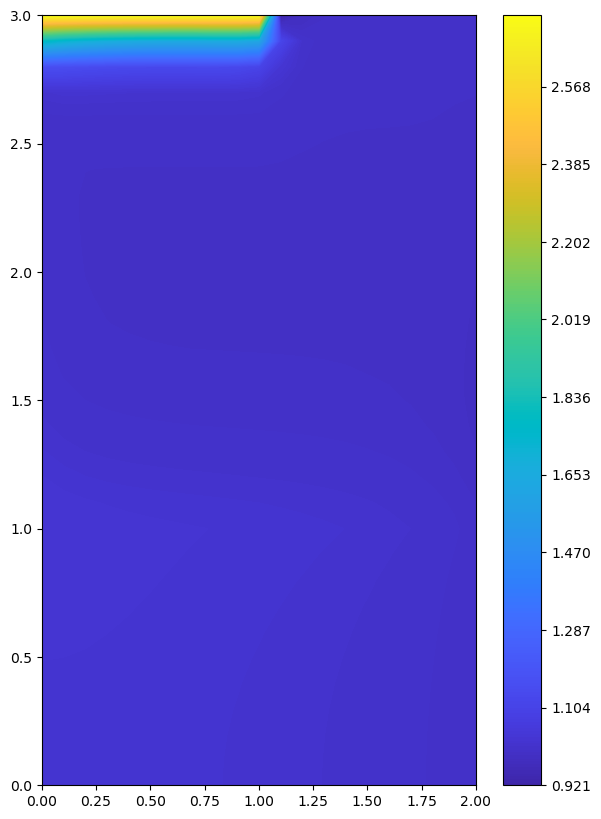

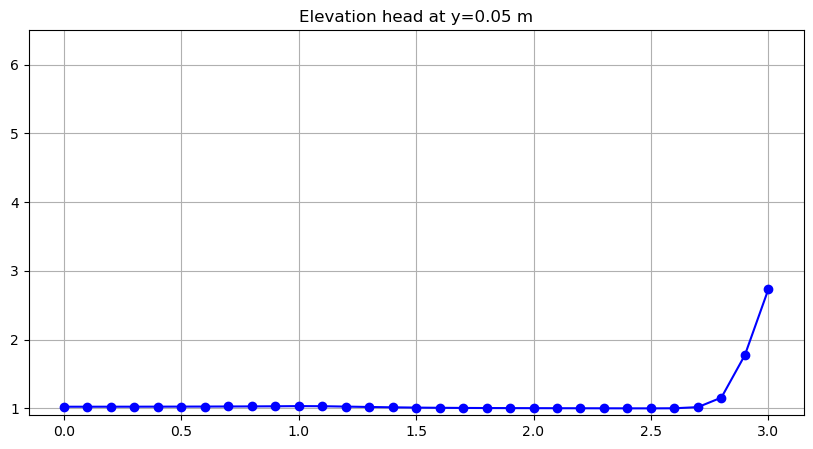

Time 0.04167
Iteration #0001, error L2 relative psi:    0.53049064191851
Iteration #0002, error L2 relative psi:    0.26750997862703
Iteration #0003, error L2 relative psi:    0.10208892756206
Iteration #0004, error L2 relative psi:    0.03283683126522
Iteration #0005, error L2 relative psi:    0.01151014897917
Iteration #0006, error L2 relative psi:    0.00400797139800
Iteration #0007, error L2 relative psi:    0.00148671343426
Iteration #0008, error L2 relative psi:    0.00073513185976
Iteration #0009, error L2 relative psi:    0.00037070870784
Iteration #0010, error L2 relative psi:    0.00020441288756
Iteration #0011, error L2 relative psi:    0.00012221341805
Iteration #0012, error L2 relative psi:    0.00007908555244
Iteration #0013, error L2 relative psi:    0.00005206953764
Iteration #0014, error L2 relative psi:    0.00003441527122
Iteration #0015, error L2 relative psi:    0.00002293946049



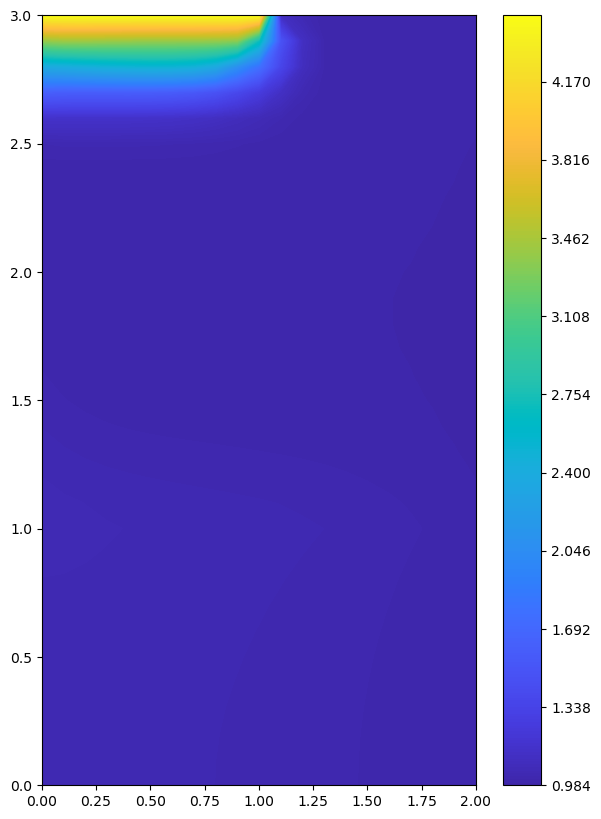

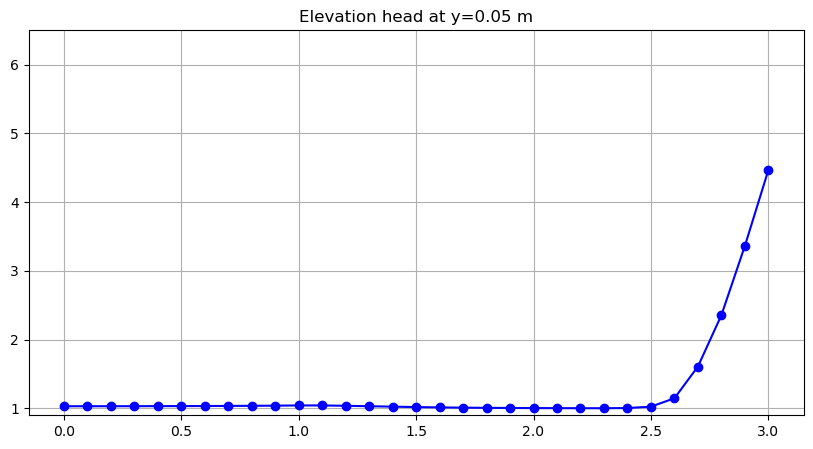

Time 0.0625
Iteration #0001, error L2 relative psi:    0.90257423526038
Iteration #0002, error L2 relative psi:    0.26556530220877
Iteration #0003, error L2 relative psi:    0.08651311644940
Iteration #0004, error L2 relative psi:    0.02705370345519
Iteration #0005, error L2 relative psi:    0.00786210473411
Iteration #0006, error L2 relative psi:    0.00201322373673
Iteration #0007, error L2 relative psi:    0.00069676642020
Iteration #0008, error L2 relative psi:    0.00029110093281
Iteration #0009, error L2 relative psi:    0.00011186170257
Iteration #0010, error L2 relative psi:    0.00005003348754
Iteration #0011, error L2 relative psi:    0.00002413729100



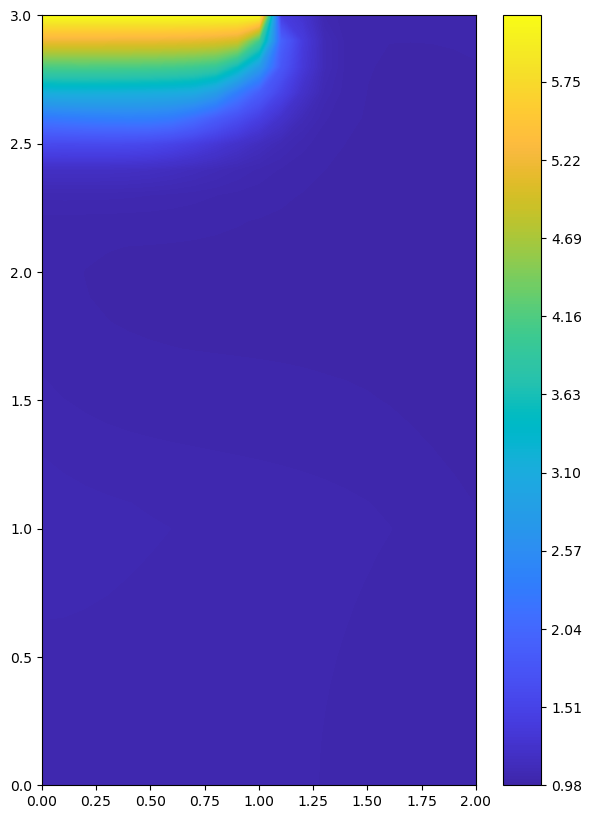

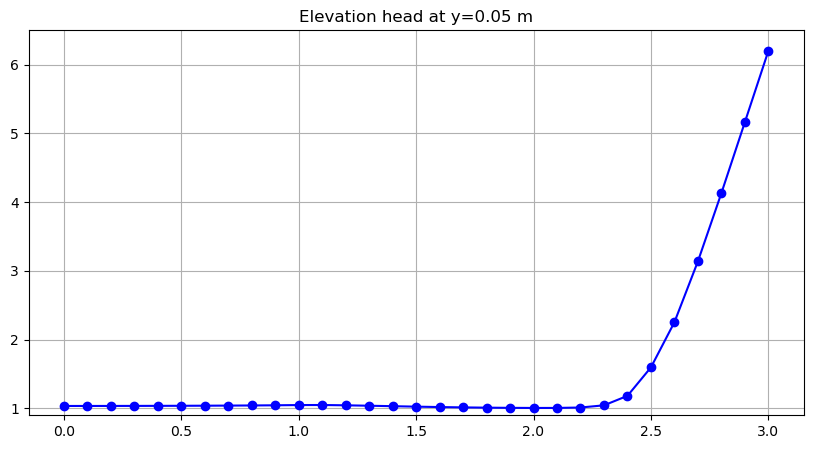

Time 0.08333
Iteration #0001, error L2 relative psi:    0.50674075176254
Iteration #0002, error L2 relative psi:    0.13560701201629
Iteration #0003, error L2 relative psi:    0.04575817284258
Iteration #0004, error L2 relative psi:    0.01394190689152
Iteration #0005, error L2 relative psi:    0.00244624657525
Iteration #0006, error L2 relative psi:    0.00116493830350
Iteration #0007, error L2 relative psi:    0.00054228871317
Iteration #0008, error L2 relative psi:    0.00028816864890
Iteration #0009, error L2 relative psi:    0.00016360469626
Iteration #0010, error L2 relative psi:    0.00009484866758
Iteration #0011, error L2 relative psi:    0.00005642830601
Iteration #0012, error L2 relative psi:    0.00003391043577



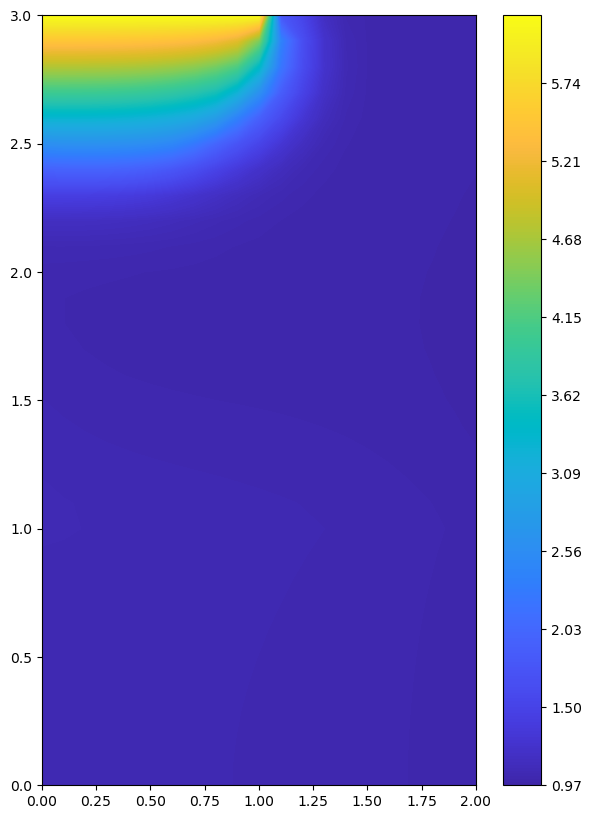

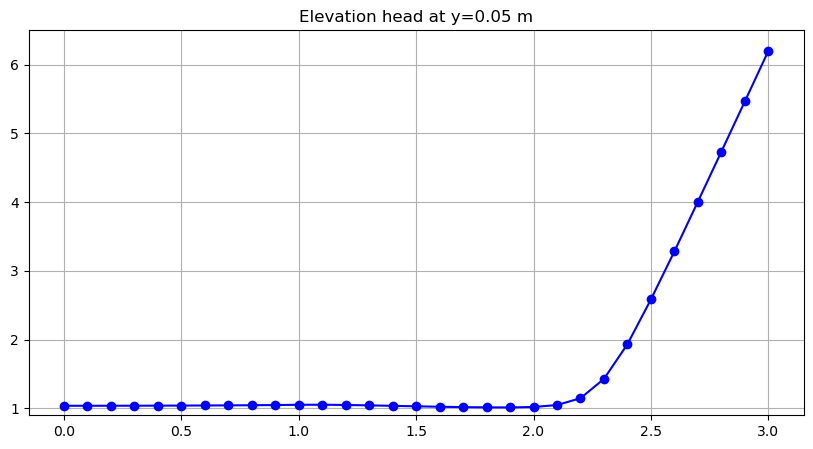

Time 0.10417
Iteration #0001, error L2 relative psi:    0.41625786292504
Iteration #0002, error L2 relative psi:    0.09425217688619
Iteration #0003, error L2 relative psi:    0.03347385427240
Iteration #0004, error L2 relative psi:    0.00849746122641
Iteration #0005, error L2 relative psi:    0.00336225359695
Iteration #0006, error L2 relative psi:    0.00190386236307
Iteration #0007, error L2 relative psi:    0.00132613077411
Iteration #0008, error L2 relative psi:    0.00099444446661
Iteration #0009, error L2 relative psi:    0.00077990344832
Iteration #0010, error L2 relative psi:    0.00062567593663
Iteration #0011, error L2 relative psi:    0.00051084452179
Iteration #0012, error L2 relative psi:    0.00042230616751
Iteration #0013, error L2 relative psi:    0.00035253965051
Iteration #0014, error L2 relative psi:    0.00029658156269
Iteration #0015, error L2 relative psi:    0.00025107534069
Iteration #0016, error L2 relative psi:    0.00021365253625
Iteration #0017, error L2 r

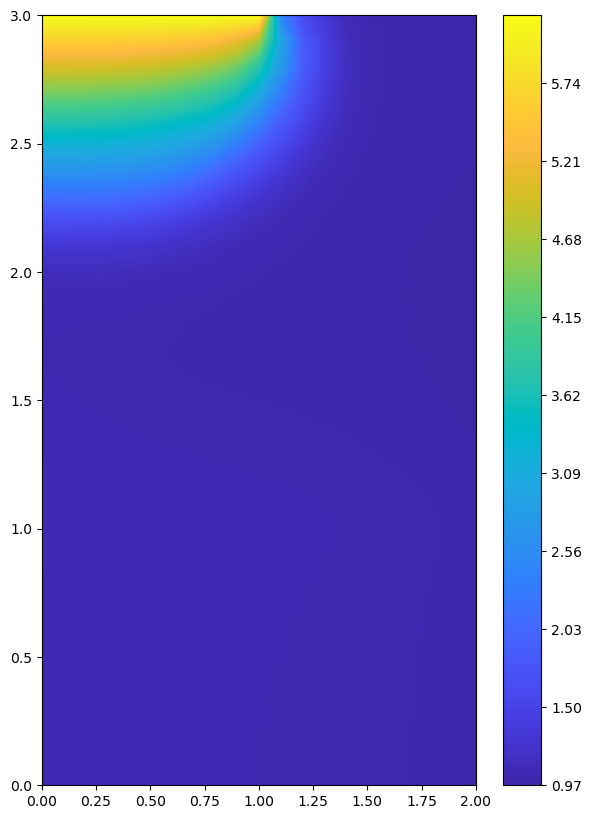

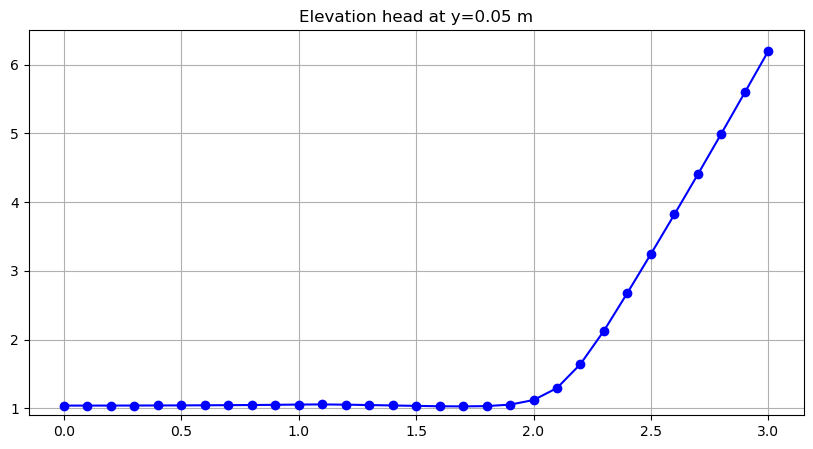

Time 0.125
Iteration #0001, error L2 relative psi:    0.36392696083512
Iteration #0002, error L2 relative psi:    0.07825333828338
Iteration #0003, error L2 relative psi:    0.03066049991592
Iteration #0004, error L2 relative psi:    0.00573764026073
Iteration #0005, error L2 relative psi:    0.00110841028370
Iteration #0006, error L2 relative psi:    0.00037293080321
Iteration #0007, error L2 relative psi:    0.00013897787037
Iteration #0008, error L2 relative psi:    0.00005470142361
Iteration #0009, error L2 relative psi:    0.00002081523372



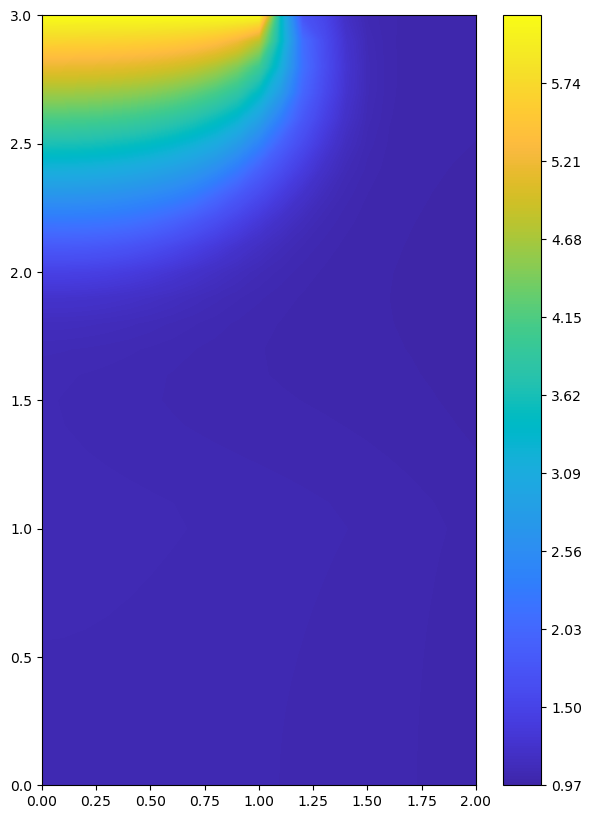

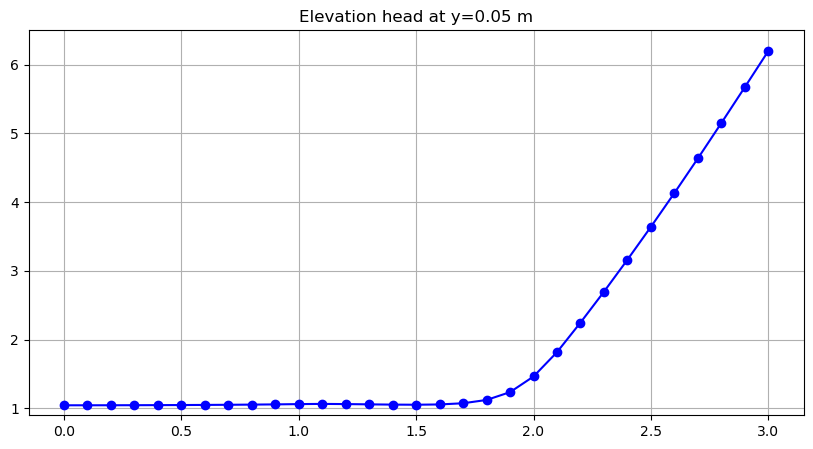

Time 0.14583
Iteration #0001, error L2 relative psi:    0.33505789065486
Iteration #0002, error L2 relative psi:    0.06803757377638
Iteration #0003, error L2 relative psi:    0.02166091541888
Iteration #0004, error L2 relative psi:    0.00358042698428
Iteration #0005, error L2 relative psi:    0.00065645967266
Iteration #0006, error L2 relative psi:    0.00023370990703
Iteration #0007, error L2 relative psi:    0.00009027805134
Iteration #0008, error L2 relative psi:    0.00003569102240



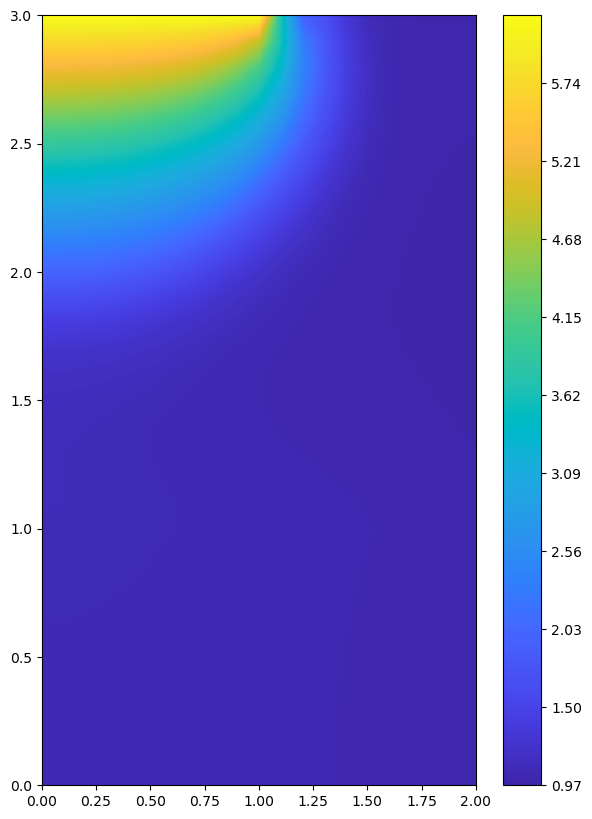

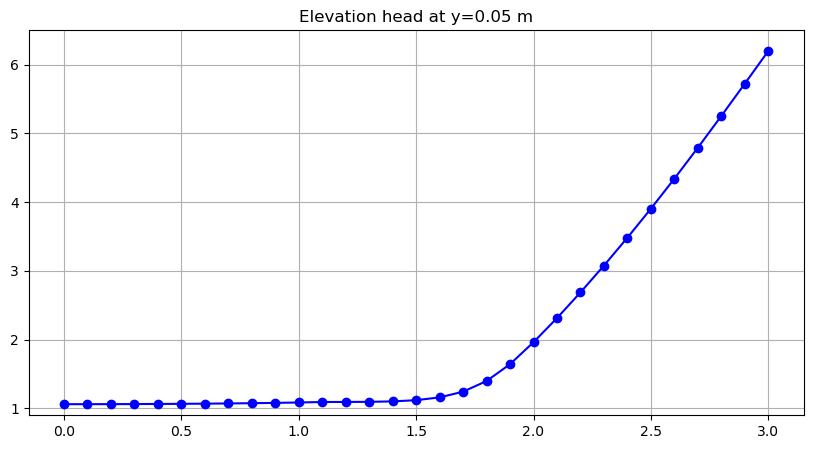

Time 0.16667
Iteration #0001, error L2 relative psi:    0.32781384284044
Iteration #0002, error L2 relative psi:    0.08630183428500
Iteration #0003, error L2 relative psi:    0.02567309380503
Iteration #0004, error L2 relative psi:    0.00534415088410
Iteration #0005, error L2 relative psi:    0.00163667357705
Iteration #0006, error L2 relative psi:    0.00095527957259
Iteration #0007, error L2 relative psi:    0.00060865682181
Iteration #0008, error L2 relative psi:    0.00040247437245
Iteration #0009, error L2 relative psi:    0.00027319476986
Iteration #0010, error L2 relative psi:    0.00018877708898
Iteration #0011, error L2 relative psi:    0.00013203678913
Iteration #0012, error L2 relative psi:    0.00009311480228
Iteration #0013, error L2 relative psi:    0.00006603151045
Iteration #0014, error L2 relative psi:    0.00004700106215



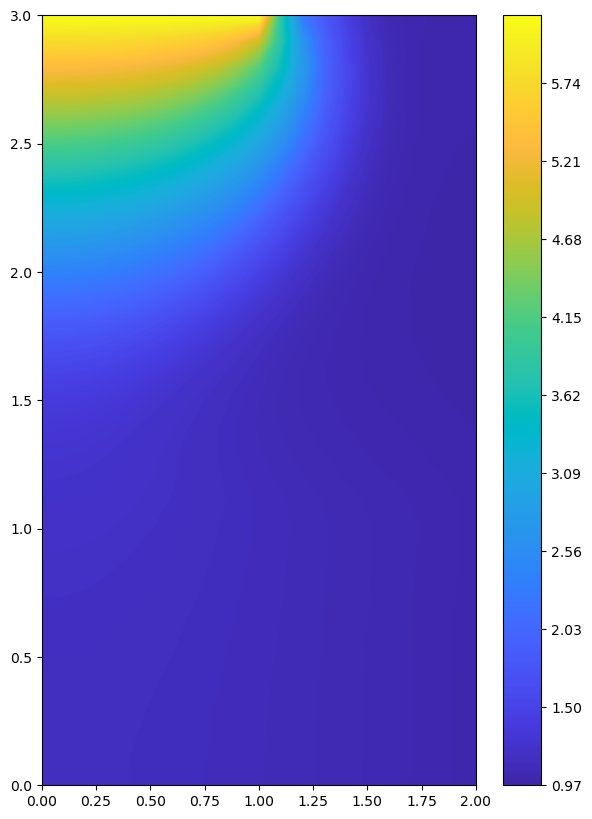

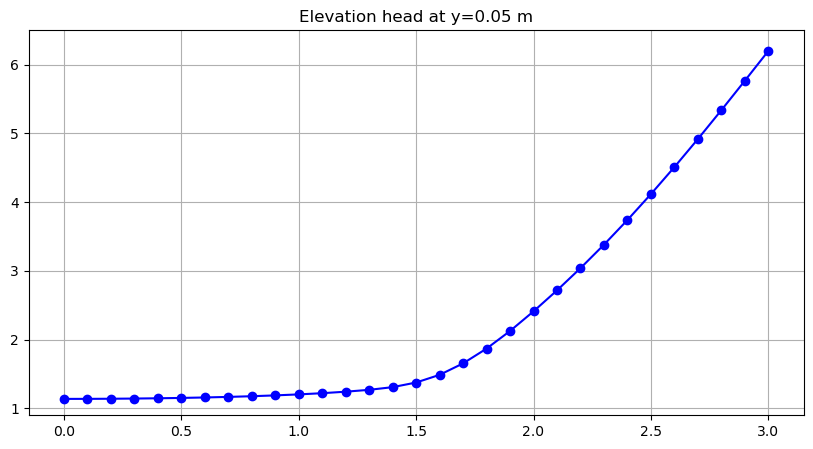

Time 0.1875
Iteration #0001, error L2 relative psi:    0.45178763239468
Iteration #0002, error L2 relative psi:    0.30871786760867
Iteration #0003, error L2 relative psi:    0.03586963307672
Iteration #0004, error L2 relative psi:    0.00926187725288
Iteration #0005, error L2 relative psi:    0.00919179179565
Iteration #0006, error L2 relative psi:    0.01207198051148
Iteration #0007, error L2 relative psi:    0.00841090113144
Iteration #0008, error L2 relative psi:    0.00487406200476
Iteration #0009, error L2 relative psi:    0.00169180273484
Iteration #0010, error L2 relative psi:    0.00089014754662
Iteration #0011, error L2 relative psi:    0.00045089070395
Iteration #0012, error L2 relative psi:    0.00021907024814
Iteration #0013, error L2 relative psi:    0.00010499869734
Iteration #0014, error L2 relative psi:    0.00005016049427



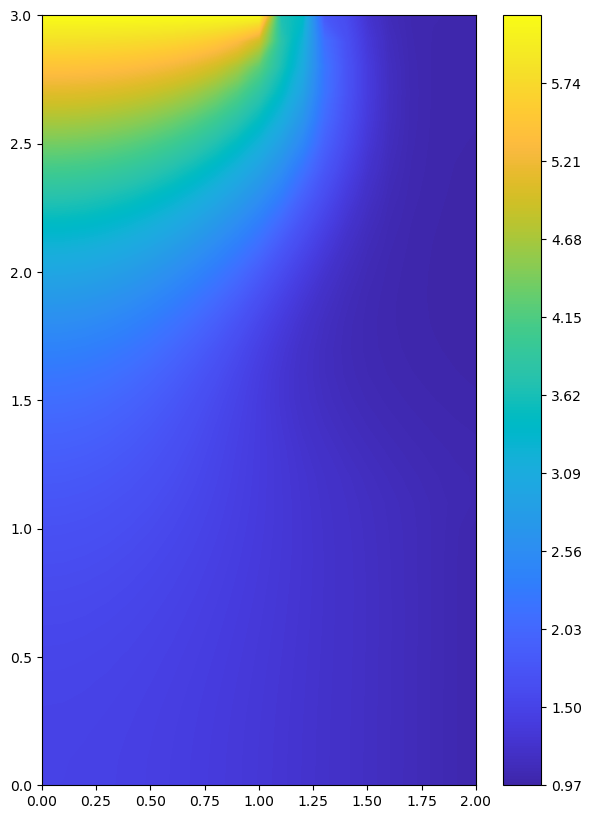

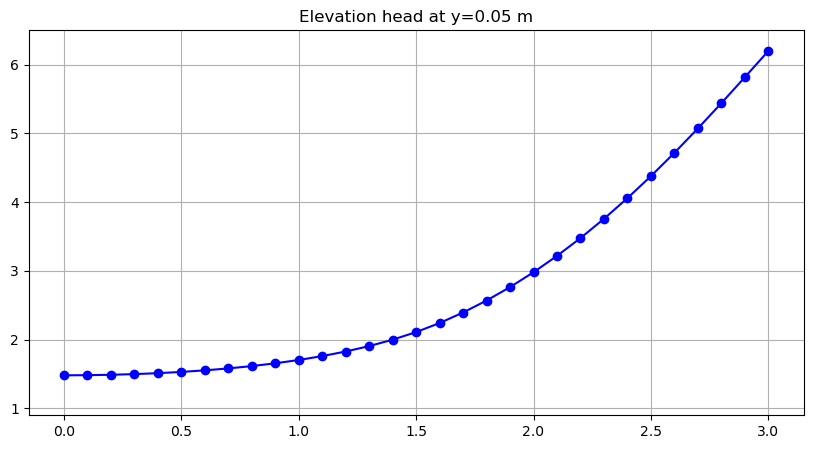

In [29]:
# Time Loop
for time_instant_index in range(1, num_steps+1):
    time = time_instant_index * dt
    print('Time ' + str(round(time, 5)))

    prev = sol

    time_rhs = np.zeros(dof_h)
    time_rhs = M_h @ theta(prev - subdomain.nodes[1,:]) / dt

    for k in range(K):
        dth = np.diag(dtheta(prev - subdomain.nodes[1,:]))

        spp = sps.bmat( dth @ M_h / dt + stifness(prev - subdomain.nodes[1,:]), format='csr')

        rhs = time_rhs.copy()

        rhs += M_h @ (dth @ prev - theta(prev - subdomain.nodes[1,:])) / dt

        ls = pg.LinearSystem(spp, rhs)
        ls.flag_ess_bc( dirichlet_flag, dirichlet_value(time) )

        current = ls.solve()

        # Check if we have reached convergence
        rel_err_psi  = np.sqrt( (current - prev).T @ M_h @ (current - prev) )
        abs_err_prev = np.sqrt( prev.T @ M_h @ prev )

        # Log message with error and current iteration
        print('Iteration #' + format(k+1, '0' + str(ceil(log10(K)) + 1) + 'd') + ', error L2 relative psi: ' 
              + format(rel_err_psi, str(5 + ceil(log10(1 / abs_tol)) + 4) + '.' + str(ceil(log10(1 / abs_tol)) + 4) + 'f') )
        
        if rel_err_psi > abs_tol + rel_tol * abs_err_prev:
            prev = current.copy()
        else:
            break
        
    print('')    
    sol = current
    
    save_step(sol, saver, time_instant_index)

    export_csv(time_instant_index, sol, True, True)



saver.write_pvd([n * dt for n in range(num_steps + 1)])